### Predicting whether the user gave rating below 8 or above(or equal to) 8 based on his/her review

In [1]:
import pandas as pd
import numpy as np 
import kaggle

In [2]:
#kaggle.api.dataset_download_files('beridzeg45/my-favorite-movies','csv_files',quiet=False,unzip=True)

### Preprocessing

In [3]:
df=pd.read_csv('csv_files/IMDB_reviews.csv')

In [4]:
df=df[['Review Text','Rating By User']]

In [5]:
df['Rating By User']=df['Rating By User'].apply(lambda x:x.split('/')[0] if isinstance(x,str) else None).apply(pd.to_numeric,errors='coerce')

In [6]:
df['Rating By User']=df['Rating By User'].apply(lambda x:1 if x>=8 else 0)

In [7]:
df=df.dropna(how='any')

In [8]:
df=df.sample(5000).sample(frac=1).reset_index(drop=True)

<Axes: ylabel='count'>

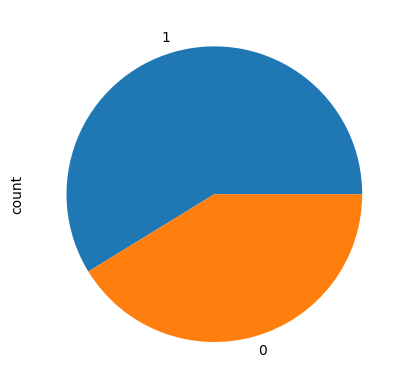

In [23]:
df['Rating By User'].value_counts().plot.pie()

##### Define vectors dictionary

In [9]:
vector_dict={}
with open('csv_files/glove.6B/glove.6B.50d.txt','r',encoding='utf-8') as f:
    lines=f.readlines()
    for line in lines:
        try:
            line=line.split(' ')
            vector_dict[line[0]]=np.array(line[1:],dtype=float)
        except:
            continue
len(vector_dict)

400000

##### Convert text to tokens

In [10]:
import nltk

tokenizer=nltk.RegexpTokenizer(r'\w+')
lemmatizer=nltk.stem.WordNetLemmatizer()
stopwords=nltk.corpus.stopwords.words('english')

In [11]:
def text_to_tokens(text):
    tokenized=tokenizer.tokenize(text)
    lower=[t.lower() for t in tokenized]
    lemmatized=[lemmatizer.lemmatize(t) for t in lower]
    tokens=[t for t in lemmatized if t in vector_dict]
    
    return tokens

##### Create list of vectors for each text

In [12]:
def text_to_vector_list(text):
    text_as_tokens=text_to_tokens(text)

    vectors_list=[]
    for token in text_as_tokens:
        if token not in vector_dict:
            continue
        vector=vector_dict[token]
        vectors_list.append(vector)
    return np.array(vectors_list,dtype=float)

##### Split data into train, validation and test sets

In [13]:
split_index_1=int(len(df)*0.7)
split_index_2=int(len(df)*0.85)

train, val, test=df.iloc[:split_index_1],df.iloc[split_index_1:split_index_2],df.iloc[split_index_2:]

len(train), len(val), len(test)

(3500, 750, 750)

##### Create vector sequences (X)

In [14]:
def df_to_Xy(df):
    y=df['Rating By User'].to_numpy().astype(int)

    vector_sequence=[]
    for text in df['Review Text']:
        vectors_list=text_to_vector_list(text)
        if vectors_list.shape[0]==0:
            vectors_list=np.zeros(shape=(1,50))
        vector_sequence.append(vectors_list)
    
    return vector_sequence,y

In [15]:
X_train,y_train=df_to_Xy(train)
X_val,y_val=df_to_Xy(val)
X_test,y_test=df_to_Xy(test)

In [16]:
length_list=[]
for i in df_to_Xy(df)[0]:
    length_list.append(i.shape[0])

In [17]:
max=0
for i in length_list:
    if i>max:
        max=i

In [18]:
max

1826

##### Padding to have uniform input data

In [19]:
from copy import deepcopy

def pad_X(X,desired_lngth=max):
    X_copy=deepcopy(X)

    for i, vectors_list in enumerate(X_copy):
        vector_length=vectors_list.shape[0]
        diff=desired_lngth-vector_length
        pad=np.zeros(shape=(diff,50))
        
        X_copy[i]=np.concatenate([vectors_list,pad])
    
    return np.array(X_copy).astype(float)

In [20]:
X_train=pad_X(X_train)

X_train.shape, y_train.shape

((3500, 1826, 50), (3500,))

In [21]:
X_val = pad_X(X_val)

X_val.shape, y_val.shape

((750, 1826, 50), (750,))

In [22]:
X_test = pad_X(X_test)

X_test.shape, y_test.shape

((750, 1826, 50), (750,))

# Building LSTM Model

In [24]:
from keras.layers import Dense, LSTM, Input,Dropout
from keras import layers
from keras.models import Sequential

In [34]:
model=Sequential()
model.add(Input(shape=(max,50)))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(layers.Flatten())
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1826, 64)          29440     
                                                                 
 dropout_1 (Dropout)         (None, 1826, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 116864)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 116865    
                                                                 
Total params: 146305 (571.50 KB)
Trainable params: 146305 (571.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import AUC
from keras.callbacks import ModelCheckpoint

In [36]:
cp=ModelCheckpoint('model/',save_best_only=True)

In [37]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=BinaryCrossentropy(),
    metrics=['accuracy',AUC(name='auc')]
    )

In [38]:
frequencies=df['Rating By User'].value_counts()
frequencies

Rating By User
1    2938
0    2062
Name: count, dtype: int64

In [39]:
weights={0:frequencies.sum()/frequencies[0],1:frequencies.sum()/frequencies[1]}
weights

{0: 2.4248302618816684, 1: 1.7018379850238257}

In [40]:
model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=20,callbacks=[cp],class_weight=weights)

Epoch 1/20


110/110 [==============================] - ETA: 0s - loss: 1.3916 - accuracy: 0.5109 - auc: 0.5272INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


110/110 [==============================] - 61s 538ms/step - loss: 1.3916 - accuracy: 0.5109 - auc: 0.5272 - val_loss: 0.6728 - val_accuracy: 0.6027 - val_auc: 0.5938
Epoch 2/20
110/110 [==============================] - ETA: 0s - loss: 1.3604 - accuracy: 0.5846 - auc: 0.6038INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


110/110 [==============================] - 65s 593ms/step - loss: 1.3604 - accuracy: 0.5846 - auc: 0.6038 - val_loss: 0.6696 - val_accuracy: 0.6053 - val_auc: 0.6104
Epoch 3/20
110/110 [==============================] - ETA: 0s - loss: 1.3229 - accuracy: 0.6020 - auc: 0.6466INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


110/110 [==============================] - 70s 635ms/step - loss: 1.3229 - accuracy: 0.6020 - auc: 0.6466 - val_loss: 0.6612 - val_accuracy: 0.6293 - val_auc: 0.6253
Epoch 4/20
110/110 [==============================] - 47s 430ms/step - loss: 1.2747 - accuracy: 0.6457 - auc: 0.6959 - val_loss: 0.6924 - val_accuracy: 0.5693 - val_auc: 0.6253
Epoch 5/20
110/110 [==============================] - 48s 436ms/step - loss: 1.2447 - accuracy: 0.6643 - auc: 0.7193 - val_loss: 0.6774 - val_accuracy: 0.6013 - val_auc: 0.6361
Epoch 6/20
110/110 [==============================] - ETA: 0s - loss: 1.1981 - accuracy: 0.6880 - auc: 0.7523INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


110/110 [==============================] - 50s 452ms/step - loss: 1.1981 - accuracy: 0.6880 - auc: 0.7523 - val_loss: 0.6437 - val_accuracy: 0.6693 - val_auc: 0.6729
Epoch 7/20
110/110 [==============================] - 74s 674ms/step - loss: 1.1683 - accuracy: 0.7017 - auc: 0.7721 - val_loss: 0.6480 - val_accuracy: 0.6587 - val_auc: 0.6754
Epoch 8/20
110/110 [==============================] - 72s 657ms/step - loss: 1.1424 - accuracy: 0.7074 - auc: 0.7789 - val_loss: 0.6590 - val_accuracy: 0.6320 - val_auc: 0.6799
Epoch 9/20
110/110 [==============================] - 62s 568ms/step - loss: 1.1075 - accuracy: 0.7186 - auc: 0.8007 - val_loss: 0.6474 - val_accuracy: 0.6573 - val_auc: 0.6852
Epoch 10/20
110/110 [==============================] - ETA: 0s - loss: 1.0751 - accuracy: 0.7366 - auc: 0.8151INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


110/110 [==============================] - 69s 627ms/step - loss: 1.0751 - accuracy: 0.7366 - auc: 0.8151 - val_loss: 0.6412 - val_accuracy: 0.6733 - val_auc: 0.6920
Epoch 11/20
110/110 [==============================] - ETA: 0s - loss: 1.0537 - accuracy: 0.7511 - auc: 0.8239INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


110/110 [==============================] - 70s 641ms/step - loss: 1.0537 - accuracy: 0.7511 - auc: 0.8239 - val_loss: 0.6361 - val_accuracy: 0.6787 - val_auc: 0.6929
Epoch 12/20
110/110 [==============================] - 61s 555ms/step - loss: 1.0319 - accuracy: 0.7526 - auc: 0.8342 - val_loss: 0.7080 - val_accuracy: 0.6093 - val_auc: 0.6791
Epoch 13/20
110/110 [==============================] - 62s 563ms/step - loss: 1.0126 - accuracy: 0.7606 - auc: 0.8415 - val_loss: 0.6447 - val_accuracy: 0.6707 - val_auc: 0.6968
Epoch 14/20
110/110 [==============================] - 63s 575ms/step - loss: 0.9805 - accuracy: 0.7654 - auc: 0.8548 - val_loss: 0.6379 - val_accuracy: 0.6707 - val_auc: 0.6998
Epoch 15/20
110/110 [==============================] - 62s 563ms/step - loss: 0.9568 - accuracy: 0.7811 - auc: 0.8620 - val_loss: 0.6772 - val_accuracy: 0.6400 - val_auc: 0.6939
Epoch 16/20
110/110 [==============================] - 61s 559ms/step - loss: 0.9369 - accuracy: 0.7906 - auc: 0.8709 - va

In [41]:
from keras.models import load_model

best_model = load_model('model/')

In [42]:
test_predictions = (best_model.predict(X_test) > 0.5).astype(int)

from sklearn.metrics import classification_report

print(classification_report(y_test, test_predictions))

24/24 [==============================] - 5s 202ms/step
              precision    recall  f1-score   support

           0       0.66      0.52      0.58       310
           1       0.71      0.81      0.75       440

    accuracy                           0.69       750
   macro avg       0.68      0.67      0.67       750
weighted avg       0.69      0.69      0.68       750



<Axes: >

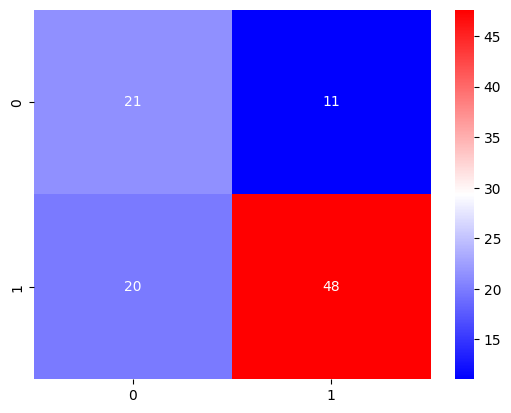

In [43]:
from sklearn import metrics

cm=metrics.confusion_matrix(test_predictions,y_test)
cm=cm/cm.sum()*100

import seaborn as sns

sns.heatmap(cm,annot=True,cmap='bwr')